Import Library yang Dibutuhkan

In [1]:
import os
import pickle
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scikeras.wrappers import KerasClassifier

Fungsi Ekstraksi Fitur

In [2]:
def extract_features(audio_path, n_mfcc=40, max_pad_len=None):
    try:
        # Load file audio
        y, sr = librosa.load(audio_path, sr=None)

        # Ekstraksi fitur MFCC
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfccs = np.mean(mfccs.T, axis=0)

        # Ekstraksi fitur Zero Crossing Rate (ZCR)
        zcr = librosa.feature.zero_crossing_rate(y=y)
        zcr = np.mean(zcr.T, axis=0)

        # Ekstraksi fitur Spectral Centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_centroid = np.mean(spectral_centroid.T, axis=0)

        # Gabungkan semua fitur
        features = np.hstack([mfccs, zcr, spectral_centroid])

        # Padding atau truncate agar panjang fitur seragam
        if max_pad_len is not None:
            if len(features) < max_pad_len:
                pad_width = max_pad_len - len(features)
                features = np.pad(features, (0, pad_width), mode='constant')
            else:
                features = features[:max_pad_len]

        return features

    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

Fungsi Load Data dan Memanggil Fungsi Ekstraksi Fitur

In [3]:
def load_and_extract(base_dir, labels, n_mfcc=40, max_pad_len=None):
    data = []

    for label in labels:
        path = os.path.join(base_dir, label)
        if not os.path.exists(path):
            # Tidak ditemukan direktori
            print(f"Warning: Directory '{path}' not found. Skipping label '{label}'.")
            continue
        for filename in os.listdir(path):
            if filename.endswith('.wav'):
                filepath = os.path.join(path, filename)
                features = extract_features(filepath, n_mfcc, max_pad_len)
                if features is not None:
                    data.append({'filepath': filepath, 'sentiment': label, 'features': features})

    df = pd.DataFrame(data)
    df.dropna(inplace=True)
    return df

Fungsi Augmentasi Data

In [4]:
def augment_audio(audio_path, sr_orig, output_dir="temp_augmented_audio"):
    y, _ = librosa.load(audio_path, sr=sr_orig)

    augmented_waves_info = []
    os.makedirs(output_dir, exist_ok=True)

    # Augmentasi data penambahan Noise (white noise)
    noise_amplitude = 0.005 * np.random.uniform() * np.amax(y)
    y_noise = y + noise_amplitude * np.random.normal(size=y.shape[0])
    temp_path_noise = os.path.join(output_dir, f"aug_noise_{os.path.basename(audio_path)}")
    sf.write(temp_path_noise, y_noise, sr_orig)
    augmented_waves_info.append((temp_path_noise, y_noise))

    # Augmentasi data pergeseran Pitch (semitone = -2 atau 2)
    y_pitch_down = librosa.effects.pitch_shift(y=y, sr=sr_orig, n_steps=-2)
    temp_path_pitch_down = os.path.join(output_dir, f"aug_pitch_down_{os.path.basename(audio_path)}")
    sf.write(temp_path_pitch_down, y_pitch_down, sr_orig)
    augmented_waves_info.append((temp_path_pitch_down, y_pitch_down))

    y_pitch_up = librosa.effects.pitch_shift(y=y, sr=sr_orig, n_steps=2)
    temp_path_pitch_up = os.path.join(output_dir, f"aug_pitch_up_{os.path.basename(audio_path)}")
    sf.write(temp_path_pitch_up, y_pitch_up, sr_orig)
    augmented_waves_info.append((temp_path_pitch_up, y_pitch_up))

    # Augmentasi data pergeseran Waktu (time stretching)
    rate = np.random.uniform(0.8, 1.2)
    y_stretch = librosa.effects.time_stretch(y=y, rate=rate)
    temp_path_stretch = os.path.join(output_dir, f"aug_stretch_{os.path.basename(audio_path)}")

    sf.write(temp_path_stretch, y_stretch, sr_orig)
    augmented_waves_info.append((temp_path_stretch, y_stretch))

    return augmented_waves_info

Fungsi Memanggil Augmentasi Data dan Ekstraksi Fitur

In [5]:
def augment_and_extract(df_original, max_pad_len, output_dir="temp_augmented_audio"):
    augmented_data = []

    # Tambahkan data asli
    for index, row in df_original.iterrows():
        augmented_data.append({'filepath': row['filepath'], 'sentiment': row['sentiment'], 'features': row['features']})

    for index, row in df_original.iterrows():
        audio_path = row['filepath']
        sentiment = row['sentiment']
        _, sr_orig = librosa.load(audio_path, sr=None)
        augmented_waves_info = augment_audio(audio_path, sr_orig, output_dir)
        for temp_audio_path, _ in augmented_waves_info:
            aug_features = extract_features(temp_audio_path, max_pad_len=max_pad_len)
            if aug_features is not None:
                augmented_data.append({'filepath': temp_audio_path, 'sentiment': sentiment, 'features': aug_features})
            os.remove(temp_audio_path)

    # Hapus direktori sementara jika kosong
    if os.path.exists(output_dir) and not os.listdir(output_dir):
        os.rmdir(output_dir)

    augmented_df = pd.DataFrame(augmented_data)
    augmented_df.dropna(inplace=True)
    return augmented_df

Fungsi Model CNN

In [6]:
def cnn(input_shape, num_classes, filters_conv1=64, kernel_size_conv1=5, dropout_rate1=0.3,filters_conv2=128, kernel_size_conv2=5, dropout_rate2=0.3, dense_units=128, dropout_rate_dense=0.4, learning_rate=0.001): # Ensure learning_rate is an argument here
    # Pembangunan layer model
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=filters_conv1, kernel_size=kernel_size_conv1, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(dropout_rate1),

        Conv1D(filters=filters_conv2, kernel_size=kernel_size_conv2, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(dropout_rate2),

        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate_dense),
        Dense(num_classes, activation='softmax')
    ])
    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Fungsi Pelatihan, Hyperparameter Tuning, Cross Validation, dan Evaluasi

In [7]:
def train_and_evaluate(train_dir, labels, model_save_path='model_artifacts', n_mfcc=40, max_pad_len=None):
    os.makedirs(model_save_path, exist_ok=True)

    # Memulai load dan ekstraksi fitur data asli
    print("\nMemuat dan mengekstrak fitur dari data asli...")
    df_original = load_and_extract(train_dir, labels, n_mfcc, max_pad_len)
    if df_original.empty:
        print("Error: Tidak ada data ditemukan di direktori training.")
        return

    # Memulai augmentasi data dab ekstraksi fitur data augmented
    print("\nMelakukan augmentasi data dan ekstraksi fitur...")
    augmented_df = augment_and_extract(df_original, max_pad_len)

    # Pisah fitur dan label
    X = np.array(augmented_df['features'].tolist())
    y = augmented_df['sentiment'].values

    # Encode label
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)
    num_classes = len(encoder.classes_)
    print(f"\nJumlah kelas sentimen: {num_classes}")
    print(f"Label: {encoder.classes_}")

    # Normalisasi fitur
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    input_shape = (X_scaled.shape[1], 1)

    print(f"Total data setelah augmentasi: {len(augmented_df)} file")
    print(f"Dimensi fitur setelah scaling: {X_scaled.shape}")
    print(f"Dimensi input CNN: {input_shape}")

    # Hyperparameter tuning dengan RandomizedSearchCV
    def create_model_for_tuning(input_shape, 
                                num_classes, 
                                filters_conv1=64, 
                                kernel_size_conv1=5, 
                                dropout_rate1=0.3,
                                filters_conv2=128, 
                                kernel_size_conv2=5, 
                                dropout_rate2=0.3,
                                dense_units=128, 
                                dropout_rate_dense=0.4, 
                                learning_rate=0.001):
        return cnn(input_shape, 
                   num_classes, 
                   filters_conv1, 
                   kernel_size_conv1, 
                   dropout_rate1,
                   filters_conv2, kernel_size_conv2, 
                   dropout_rate2,
                   dense_units, 
                   dropout_rate_dense, 
                   learning_rate)

    keras_model = KerasClassifier(model=create_model_for_tuning,
                                  input_shape=input_shape,
                                  num_classes=num_classes, 
                                  verbose=0)

    param_grid = {
        'model__filters_conv1': [32, 64],
        'model__kernel_size_conv1': [3, 5],
        'model__dropout_rate1': [0.2, 0.3],
        'model__filters_conv2': [64, 128],
        'model__kernel_size_conv2': [3, 5],
        'model__dropout_rate2': [0.2, 0.3],
        'model__dense_units': [64, 128],
        'model__dropout_rate_dense': [0.3, 0.4],
        'model__learning_rate': [0.001, 0.0005],
        'batch_size': [32, 64],
        'epochs': [50, 75]  
    }

    print("\nMelakukan Hyperparameter Tuning dengan RandomizedSearchCV dan Cross-Validation...")

    # Membagi data menjadi 5 fold untuk cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    random_search = RandomizedSearchCV(estimator=keras_model,
                                       param_distributions=param_grid,
                                       n_iter=10,
                                       cv=cv,
                                       scoring='accuracy',
                                       verbose=2,
                                       n_jobs=-1,
                                       random_state=42)

    X_scaled_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

    random_search.fit(X_scaled_reshaped, y_encoded)

    print("\nHasil Hyperparameter Tuning terbaik:")
    print(f"Best Score: {random_search.best_score_}")
    print(f"Best Parameters: {random_search.best_params_}")

    print("\nMelatih model dengan parameter terbaik pada seluruh dataset...")
    best_params = random_search.best_params_

    final_model_params = {k.replace('model__', ''): v for k, v in best_params.items() if k.startswith('model__')}

    final_model = cnn(input_shape, num_classes, **final_model_params)

    # Early stopping dan learning rate reduction untuk mencegah overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

    # Split dataset
    X_train, X_val, y_train, y_val = train_test_split(X_scaled_reshaped, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

    # Melatih model akhir dengan parameter terbaik
    history = final_model.fit(X_train, y_train,
                              validation_data=(X_val, y_val),
                              epochs=best_params['epochs'], 
                              batch_size=best_params['batch_size'],
                              callbacks=[early_stopping, reduce_lr],
                              verbose=1)

    # Simpan model, scaler, dan encoder
    model_filepath = os.path.join(model_save_path, 'best_sentiment_model.keras')
    scaler_filepath = os.path.join(model_save_path, 'scaler.pkl')
    encoder_filepath = os.path.join(model_save_path, 'encoder.pkl')

    final_model.save(model_filepath)
    with open(scaler_filepath, 'wb') as f:
        pickle.dump(scaler, f)
    with open(encoder_filepath, 'wb') as f:
        pickle.dump(encoder, f)

    print(f"\nModel disimpan di: {model_filepath}")
    print(f"Scaler disimpan di: {scaler_filepath}")
    print(f"Encoder disimpan di: {encoder_filepath}")

    # Evaluasi model akhir pada data validasi
    print("\nEvaluasi model akhir pada data validasi:")
    val_loss, val_accuracy = final_model.evaluate(X_val, y_val, verbose=0)
    print(f"Loss Validasi: {val_loss:.4f}")
    print(f"Akurasi Validasi: {val_accuracy:.4f}")

    # Plotting riwayat training
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Classification report dan confusion matrix pada data validasi
    y_pred_val = np.argmax(final_model.predict(X_val), axis=1)
    print("\nClassification Report (Validation Set):")
    print(classification_report(y_val, y_pred_val, target_names=labels))

    cm_val = confusion_matrix(y_val, y_pred_val)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix (Validation Set)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    return final_model, scaler, encoder

Main Program untuk Eksekusi Seluruh Kode

Ditemukan Max Pad Length optimal: 42

Memuat dan mengekstrak fitur dari data asli...

Melakukan augmentasi data dan ekstraksi fitur...

Jumlah kelas sentimen: 3
Label: ['Negative' 'Neutral' 'Positive']
Total data setelah augmentasi: 1250 file
Dimensi fitur setelah scaling: (1250, 42)
Dimensi input CNN: (42, 1)

Melakukan Hyperparameter Tuning dengan RandomizedSearchCV dan Cross-Validation...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Hasil Hyperparameter Tuning terbaik:
Best Score: 0.9512
Best Parameters: {'model__learning_rate': 0.001, 'model__kernel_size_conv2': 5, 'model__kernel_size_conv1': 3, 'model__filters_conv2': 128, 'model__filters_conv1': 32, 'model__dropout_rate_dense': 0.4, 'model__dropout_rate2': 0.3, 'model__dropout_rate1': 0.2, 'model__dense_units': 64, 'epochs': 50, 'batch_size': 64}

Melatih model dengan parameter terbaik pada seluruh dataset...
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4757 - loss: 1.0357 - val_accuracy: 0.79

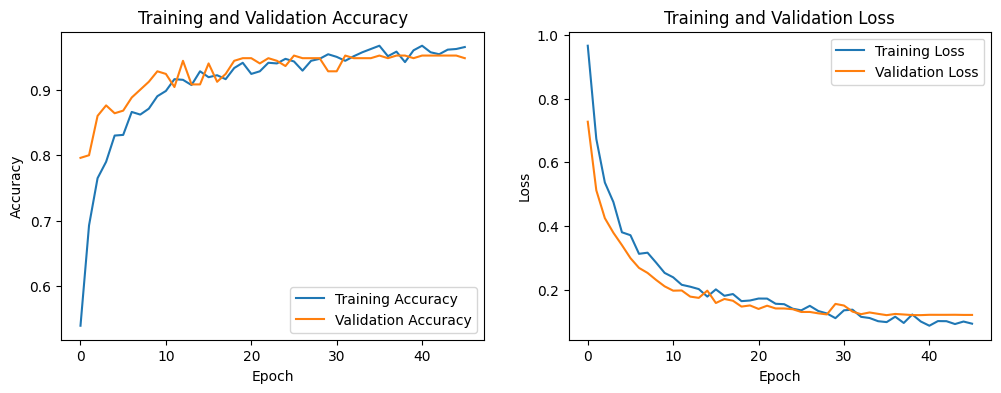

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Classification Report (Validation Set):
              precision    recall  f1-score   support

    Positive       0.91      0.95      0.93        87
     Neutral       1.00      0.99      0.99        81
    Negative       0.95      0.91      0.93        82

    accuracy                           0.95       250
   macro avg       0.95      0.95      0.95       250
weighted avg       0.95      0.95      0.95       250



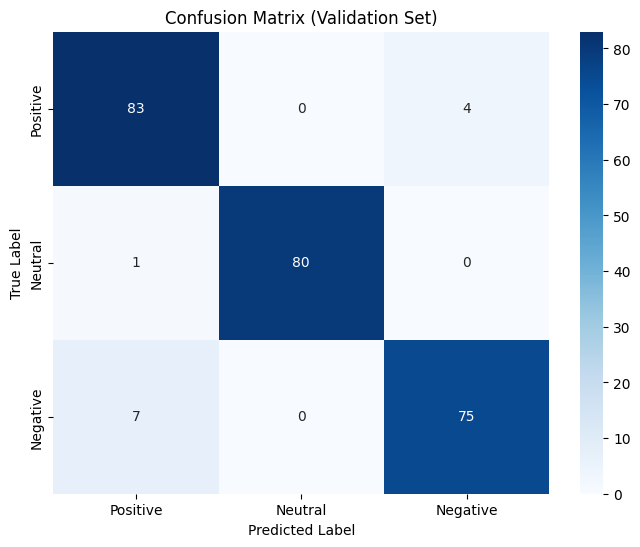

In [8]:
if __name__ == '__main__':
    TRAIN_DIR = 'C:/Belajar Coding/PPDM/Audio Speech Sentiment Analysis/Dataset/TRAIN'
    SENTIMENT_LABELS = ['Positive', 'Neutral', 'Negative']
    
    temp_df = load_and_extract(TRAIN_DIR, SENTIMENT_LABELS, max_pad_len=None)
    if not temp_df.empty:
        features_lengths = [len(f) for f in temp_df['features']]
        # Menghitung panjang pad optimal berdasarkan persentil 95
        MAX_PAD_LENGTH = int(np.percentile(features_lengths, 95))
        if MAX_PAD_LENGTH < (40 + 2):
            MAX_PAD_LENGTH = (40 + 2) + 10
        print(f"Ditemukan Max Pad Length optimal: {MAX_PAD_LENGTH}")
    else:
        MAX_PAD_LENGTH = 174
        print(f"Data train tidak ditemukan. Menggunakan Max Pad Length default: {MAX_PAD_LENGTH}")
    
    train_and_evaluate(TRAIN_DIR, SENTIMENT_LABELS, max_pad_len=MAX_PAD_LENGTH)